# AIR QUALITY

0 Date (DD/MM/YYYY)

1 Time (HH.MM.SS)

12 Temperature in C

13 Relative Humidity

14 AH Absolute Humidity

In [5]:
import os
import numpy
import pandas
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import keras
import seaborn
import pathlib

In [3]:
# TRAINING
n_test_samples = 14
n_validation_samples = 14

# DECLARE NET
max_neurons = 20
PATIENCE = 100
MAX_EPOCHS = 10*PATIENCE
LEARNING_RATE = 0.01
HIDDEN_ACTIVATION = 'tanh'
MODEL_LOSS = 'val_loss'
MIN_IMPROVEMENT = 0.05
this_is_zero = 0.001
error_bar = 2.0
random_seed = 32

In [4]:
keras.utils.set_random_seed(random_seed)

In [6]:
# BUILD PATH TO DATA USING PATHLIB
this_folder = pathlib.Path.cwd()
data_folder = this_folder.parent
air_quality_file = data_folder / 'datasets' / 'air_quality.csv'
df = pandas.read_csv(air_quality_file, sep=';', decimal=',')


df['Date'] = pandas.to_datetime(df['Date'], format='%d/%m/%Y')
df.loc[df['T'] == -200, 'T'] = numpy.nan
df.loc[df['RH'] < 0.0, 'RH'] = numpy.nan
df.loc[df['AH'] < 0.0, 'AH'] = numpy.nan
df_day = df[['Date', 'T', 'RH', 'AH']].groupby('Date').mean()

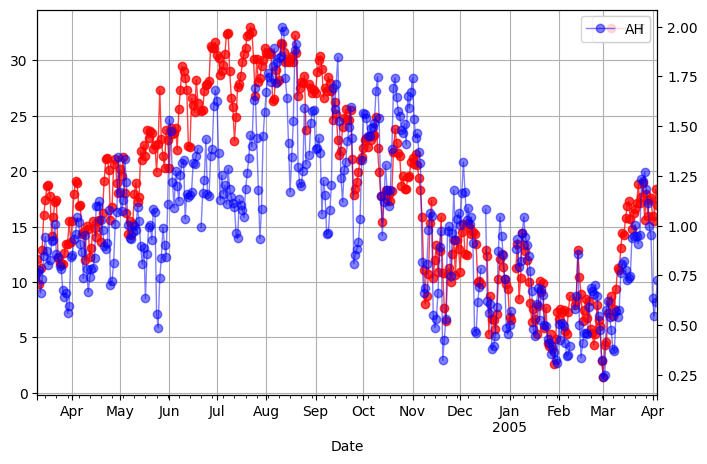

In [7]:
fig = pyplot.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
_ = df_day.plot(y='AH', ax=ax2, lw=1, marker='o', color='blue', alpha=0.5)
_ = df_day.plot(y='T', ax=ax, lw=1, marker='o', color='red', alpha=0.75)
_ = ax.grid()

In [8]:
df_day['T_d1'] = df_day['T'].shift(-1)
df_day['T_l1'] = df_day['T'].shift(1)
df_day['T_l2'] = df_day['T'].shift(2)
df_day['T_l3'] = df_day['T'].shift(3)
df_day['RH_l1'] = df_day['RH'].shift(1)
df_day['RH_l2'] = df_day['RH'].shift(2)
df_day['RH_l3'] = df_day['RH'].shift(3)
df_day['AH_l1'] = df_day['AH'].shift(1)
df_day['AH_l2'] = df_day['AH'].shift(2)
df_day['AH_l3'] = df_day['AH'].shift(3)
complete_cases = ~df_day.isna().any(axis=1)
dfn = df_day[complete_cases]

In [9]:
df_day

,T,RH,AH,T_d1,T_l1,T_l2,T_l3,RH_l1,RH_l2,RH_l3,AH_l1,AH_l2,AH_l3
Date,,,,,,,,,,,,,
2004-03-10,12.033333,54.900000,0.765633,9.837500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-11,9.837500,64.075000,0.775767,11.287500,12.033333,NaN,NaN,54.900000,NaN,NaN,0.765633,NaN,NaN
2004-03-12,11.287500,51.095833,0.663104,12.866667,9.837500,12.033333,NaN,64.075000,54.900000,NaN,0.775767,0.765633,NaN
2004-03-13,12.866667,51.533333,0.732296,16.012500,11.287500,9.837500,12.033333,51.095833,64.075000,54.900000,0.663104,0.775767,0.765633
2004-03-14,16.012500,48.850000,0.849671,17.366667,12.866667,11.287500,9.837500,51.533333,51.095833,64.075000,0.732296,0.663104,0.775767
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-03-31,17.550000,50.083333,0.951917,15.929167,17.433333,15.916667,17.933333,54.037500,62.537500,60.766667,0.996762,1.116463,1.186071
2005-04-01,15.929167,35.962500,0.636529,15.483333,17.550000,17.433333,15.916667,50.083333,54.037500,62.537500,0.951917,0.996762,1.116463
2005-04-02,15.483333,32.225000,0.546167,18.383333,15.929167,17.550000,17.433333,35.962500,50.083333,54.037500,0.636529,0.951917,0.996762


In [10]:
x_cols = ['T', 'T_l1','T_l2','T_l3','AH_l1','AH_l2','AH_l3', 'RH_l1','RH_l2','RH_l3']
y_cols = ['T_d1']
Y_name = 'T_d1'

# SAMPLING
X_trn = dfn.iloc[:-(n_validation_samples + n_test_samples)][x_cols].to_numpy()
X_val = dfn.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][x_cols].to_numpy()
X_tst = dfn[x_cols].to_numpy()
Y_trn = dfn.iloc[:-(n_validation_samples + n_test_samples)][y_cols].to_numpy()
Y_val = dfn.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][y_cols].to_numpy()
Y_tst = dfn[y_cols].to_numpy()

# SCALING X
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X_trn)
X_trn_scaled = X_scaler.transform(X_trn)
X_val_scaled = X_scaler.transform(X_val)
X_tst_scaled = X_scaler.transform(X_tst)

# SCALING Y
Y_scaler = StandardScaler()
Y_scaler = Y_scaler.fit(Y_trn)
Y_trn_scaled = Y_scaler.transform(Y_trn)
Y_val_scaled = Y_scaler.transform(Y_val)

In [11]:
X_trn_scaled.shape

(331, 10)

In [12]:
found_best_net = False
is_best_net = False
best_loss = 1000.0
best_val_loss = 1000.0
previous_val_loss = 1000.0
training_result_list = []
for n_neurons in numpy.arange(max_neurons - 1) + 2:
    inputs = keras.Input(shape=((X_trn_scaled.shape[1],)))
    hidden = keras.layers.Dense(n_neurons, activation=HIDDEN_ACTIVATION)(inputs)
    outputs = keras.layers.Dense(Y_trn_scaled.shape[1], activation='linear')(hidden)
    model_name = 'FORECAST_{}_{}'.format(HIDDEN_ACTIVATION, n_neurons)
    my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    my_net.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
    es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)
    history = my_net.fit(X_trn_scaled, Y_trn_scaled, epochs=MAX_EPOCHS, validation_data=(X_val_scaled, Y_val_scaled), batch_size=X_trn_scaled.shape[0], callbacks=[es_callback], verbose=0)
    
    hyperparameter_residual = Y_tst - Y_scaler.inverse_transform(my_net.predict(X_tst_scaled, verbose=0))
    test_mean_residual = hyperparameter_residual.mean()
    test_std_residual = hyperparameter_residual.std()
    residual_loss = test_mean_residual**2

    model_loss = (history.history['loss'][-1] + residual_loss)/2
    model_val_loss = (history.history['val_loss'][-1] + residual_loss)/2
    epochs = len(history.history['val_loss'])

    has_improved_val_loss = False
    # loss_improvement = 1.0 - model_val_loss/previous_val_loss
    # loss_improvement = (model_val_loss - previous_val_loss)/previous_val_loss
    loss_gain = previous_val_loss - model_val_loss
    loss_improvement = loss_gain / previous_val_loss if previous_val_loss != 0 else 0

    if not found_best_net or loss_improvement >= MIN_IMPROVEMENT: # keep adding neurons

        is_best_net = (model_loss <= best_loss) and (model_val_loss < best_val_loss) and (numpy.abs(test_mean_residual) <= this_is_zero)

        if is_best_net:
                best_loss = model_loss
                best_val_loss = model_val_loss
                best_net = my_net
                best_history = history
                best_text = '***BEST NET!***'
                best_name = model_name
                best_epochs = epochs
                best_mean_residual = test_mean_residual
                best_std_residual = test_std_residual
                best_residual_loss = residual_loss
                found_best_net = True
        else:
            best_text = ''
    else:
        print('EXTRA NEURON DIDNT IMPROVE NET {:.0f}% GAIN'.format(100.0*loss_improvement))
        break
    result_dict = {'model_name': model_name, 'epochs': epochs, 'model_loss': model_loss, 'model_val_loss': model_val_loss, 'best_net':is_best_net, 'history': history}
    training_result_list.append(result_dict)
    previous_val_loss = model_val_loss
    print(f'{model_name} RESULTS > EPOCHS: {epochs} LOSS: {model_loss:.3f} VAL_LOSS: {model_val_loss:.3f} IMPROVEMENT {100.0*loss_improvement:.0f}% MEAN_RESIDUAL {test_mean_residual:.3f} RESIDUAL LOSS {residual_loss:.3f} {best_text}')

FORECAST_tanh_2 RESULTS > EPOCHS: 478 LOSS: 0.033 VAL_LOSS: 0.022 IMPROVEMENT 100% MEAN_RESIDUAL 0.067 RESIDUAL LOSS 0.004 
FORECAST_tanh_3 RESULTS > EPOCHS: 1000 LOSS: 0.026 VAL_LOSS: 0.017 IMPROVEMENT 23% MEAN_RESIDUAL 0.047 RESIDUAL LOSS 0.002 
FORECAST_tanh_4 RESULTS > EPOCHS: 1000 LOSS: 0.025 VAL_LOSS: 0.015 IMPROVEMENT 10% MEAN_RESIDUAL 0.035 RESIDUAL LOSS 0.001 
FORECAST_tanh_5 RESULTS > EPOCHS: 1000 LOSS: 0.025 VAL_LOSS: 0.015 IMPROVEMENT 2% MEAN_RESIDUAL 0.027 RESIDUAL LOSS 0.001 
FORECAST_tanh_6 RESULTS > EPOCHS: 510 LOSS: 0.025 VAL_LOSS: 0.011 IMPROVEMENT 25% MEAN_RESIDUAL 0.015 RESIDUAL LOSS 0.000 
FORECAST_tanh_7 RESULTS > EPOCHS: 534 LOSS: 0.026 VAL_LOSS: 0.019 IMPROVEMENT -76% MEAN_RESIDUAL 0.051 RESIDUAL LOSS 0.003 
FORECAST_tanh_8 RESULTS > EPOCHS: 466 LOSS: 0.024 VAL_LOSS: 0.015 IMPROVEMENT 25% MEAN_RESIDUAL 0.033 RESIDUAL LOSS 0.001 
FORECAST_tanh_9 RESULTS > EPOCHS: 560 LOSS: 0.026 VAL_LOSS: 0.015 IMPROVEMENT -3% MEAN_RESIDUAL 0.043 RESIDUAL LOSS 0.002 
FORECAST_tan

In [126]:
if not is_best_net:
    best_loss = model_loss
    best_val_loss = model_val_loss
    best_net = my_net
    best_history = history
    best_name = model_name
    best_epochs = epochs
    best_mean_residual = test_mean_residual
    best_std_residual = test_std_residual
    best_residual_loss = residual_loss

Y_est_scaled = best_net.predict(X_tst_scaled, verbose=0)
Y_est = Y_scaler.inverse_transform(Y_est_scaled)
df_day.loc[complete_cases, ['Y_est']] = Y_est
df_day['residual'] = df_day['Y_est'] - df_day['T_d1']
df_day['rabs'] = df_day['residual'].abs()
df_day['upper_bound'] = df_day['Y_est'] + error_bar*best_std_residual
df_day['lower_bound'] = df_day['Y_est'] - error_bar*best_std_residual
df_day['goal'] = ((df_day[Y_name] >= df_day['lower_bound']) & (df_day[Y_name] <= df_day['upper_bound'])).astype(int)
model_r2_score = r2_score(df_day.loc[complete_cases, 'T_d1'].to_numpy(), df_day.loc[complete_cases, 'Y_est'].to_numpy())

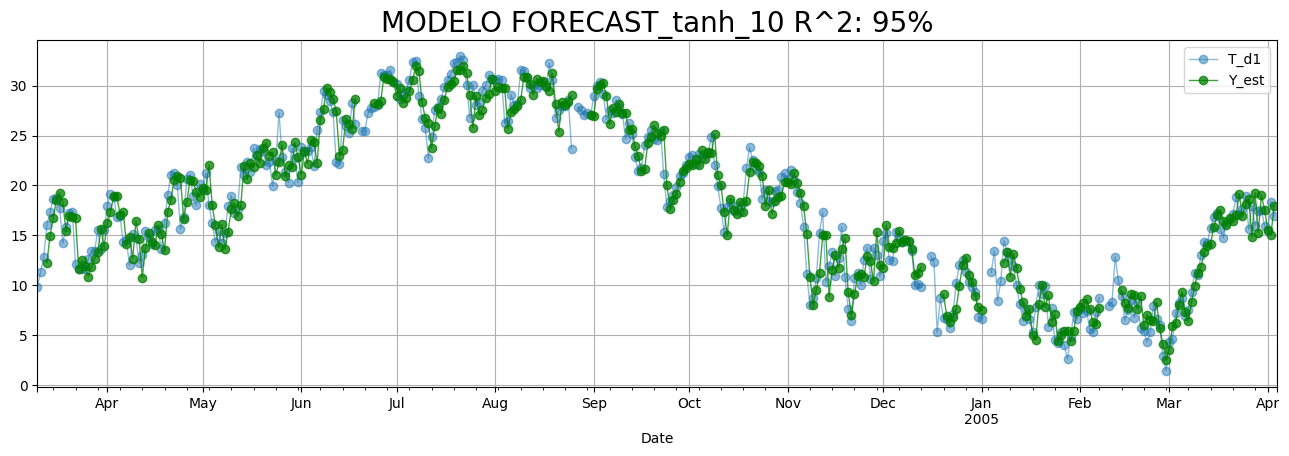

In [127]:
fig = pyplot.figure(figsize=(16, 4.5))
ax = fig.add_subplot(111)
_ = df_day.plot(y='T_d1', ax=ax, lw=1, marker='o', alpha=0.5)
_ = df_day.plot(y='Y_est', ax=ax, lw=1, marker='o', alpha=0.75, color='green')
_ = ax.grid()
_ = ax.set_title('MODELO {} R^2: {:.0f}%'.format(best_name, 100.0*model_r2_score), size=20)

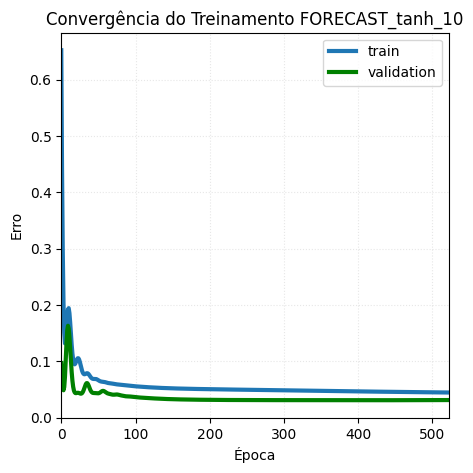

In [128]:
# plot training convergence
training_loss = best_history.history['loss']
validation_loss = best_history.history['val_loss']

fig = pyplot.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
_ = ax.plot(training_loss, label='train', linewidth=3)
_ = ax.plot(validation_loss, label='validation', linewidth=3, color='green')
_ = ax.set_title(f'Convergência do Treinamento {best_name}')
_ = ax.set_xlabel('Época')
_ = ax.set_ylabel('Erro')
_ = ax.legend()
_ = ax.grid(alpha=0.3, linestyle=':')
_ = ax.set_xlim(0, len(training_loss))

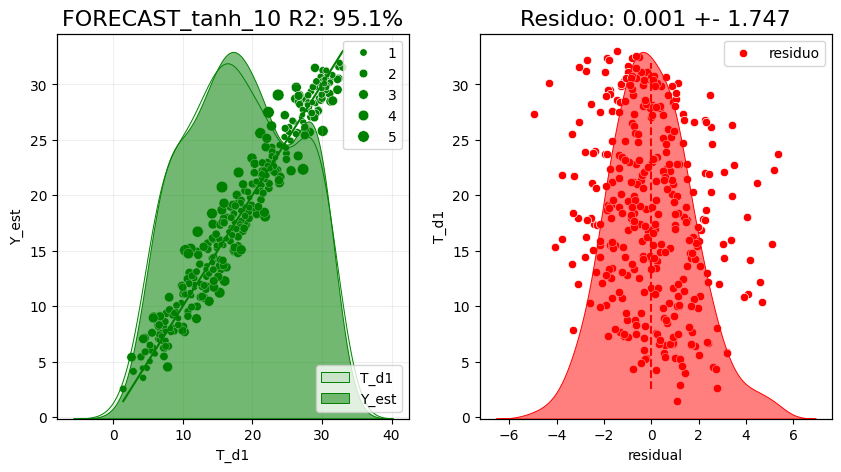

In [129]:
# STABLE RESIDUAL PLOT
r_mean = df_day.residual.median()
r_std = df_day.residual.std()
r2 = r2_score(df_day.loc[complete_cases, Y_name].to_numpy(), df_day.loc[complete_cases, 'Y_est'].to_numpy())

fig = pyplot.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
lines = seaborn.scatterplot(data=df_day, x=Y_name, y='Y_est', size='rabs', ax=ax, color='green')
_ = ax.plot([df_day[Y_name].min(), df_day[Y_name].max()], [df_day[Y_name].min(), df_day[Y_name].max()], color='green')
_ = ax.grid(alpha=0.2)
_ = ax.set_title('{} R2: {:.1f}%'.format(best_name,100.0*r2), size=16)
ax2 = ax.twinx()
_ = seaborn.kdeplot(data=df_day, x=Y_name, ax=ax2, label=Y_name, color='green', fill=True, alpha=0.1, linewidth=0.7)
_ = seaborn.kdeplot(data=df_day, x='Y_est', ax=ax2, label='Y_est', color='green', fill=True, alpha=0.5, linewidth=0.7)
_ = ax2.set_ylabel('')
_ = ax2.set_yticks([])
_ = ax.legend(loc='upper right')
_ = ax2.legend(loc='lower right')
ax3 = fig.add_subplot(122)
_ = seaborn.scatterplot(data=df_day, x='residual', y=Y_name, ax=ax3, label='residuo', color='red')
ax4 = ax3.twinx()
_ = seaborn.kdeplot(data=df_day, x='residual', ax=ax4, label='residuo', color='red', fill=True, alpha=0.5, linewidth=0.7)
_ = ax4.grid(alpha=0.2)
_ = ax4.set_ylabel('')
_ = ax4.set_yticks([])
_ = ax4.set_title(f'Residuo: {best_mean_residual:.3f} +- {best_std_residual:.3f}', size=16)
_ = ax3.plot([best_mean_residual, best_mean_residual], [df_day.Y_est.min(), df_day.Y_est.max()], '--', color='red')

In [130]:
df_day.iloc[-n_test_samples:, :][[Y_name, 'lower_bound', 'Y_est', 'upper_bound', 'residual', 'rabs', 'goal']]

,T_d1,lower_bound,Y_est,upper_bound,residual,rabs,goal
Date,,,,,,,
2005-03-28,15.916667,15.783855,19.276957,22.770058,3.360290,3.360290,1
2005-03-29,17.433333,11.788055,15.281156,18.774256,-2.152178,2.152178,1
2005-03-30,17.550000,15.542843,19.035944,22.529045,1.485944,1.485944,1
2005-03-31,15.929167,14.022945,17.516047,21.009148,1.586880,1.586880,1
2005-04-01,15.483333,12.050165,15.543265,19.036366,0.059932,0.059932,1
2005-04-02,18.383333,11.588823,15.081923,18.575024,-3.301410,3.301410,1
2005-04-03,16.960000,14.482622,17.975723,21.468824,1.015723,1.015723,1
2005-04-04,NaN,NaN,NaN,NaN,NaN,NaN,0


In [131]:
best_net.summary()

Model: "FORECAST_tanh_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365 (1.43 KB)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244 (980.00 B)

In [132]:
best_weights = best_net.get_weights()

In [133]:
best_weights[0]

array([[ 0.32782927, -0.12091972,  0.02006744,  0.29746592,  0.02306814,
         0.6717089 , -0.48730245, -0.08283506, -0.64076614, -0.19109662],
       [-0.37280548, -0.29352623,  0.03313696,  0.15667109,  0.06338727,
         0.19985902,  0.27545455, -0.01166143, -0.21704575,  0.14520943],
       [-0.4526627 , -0.22052792,  0.08530128, -0.5936585 ,  0.17855923,
        -0.1114677 , -0.22988157,  0.05452343, -0.16414937, -0.64609444],
       [-0.4952541 ,  0.52473116, -0.618431  , -0.17978863,  0.06146047,
        -0.26888317,  0.07712062, -0.08987615, -0.48045522,  0.2670458 ],
       [ 0.2540115 ,  0.22874969, -0.5855586 , -0.15808672, -0.22701015,
        -0.11275797,  0.0082858 ,  0.37610558,  0.25357735,  0.11454346],
       [-0.4031815 , -0.16758648, -0.278302  , -0.20352155,  0.07597331,
        -0.3446715 , -0.3737701 ,  0.47690192,  0.25643057,  0.2003296 ],
       [-0.16683798, -0.46225658,  0.2510671 ,  0.14709818,  0.02763508,
         0.34992576,  0.10229672,  0.34638873

In [134]:
best_weights[1]

array([-0.52893066,  0.6725721 ,  0.6553225 ,  0.20990624,  0.2501522 ,
        0.16742669,  0.4318252 , -0.68945706, -0.46700895, -0.4408186 ],
      dtype=float32)

In [135]:
best_weights[2]

array([[-0.13863884],
       [-0.53389174],
       [-0.66462606],
       [ 0.43698877],
       [ 0.5228741 ],
       [ 0.5761081 ],
       [-0.7403903 ],
       [-0.53598577],
       [-0.4533759 ],
       [-0.4727941 ]], dtype=float32)

In [136]:
best_weights[3]

array([-0.08396062], dtype=float32)